## Participants

|Name|Group|ID|
|-|-|-|
|Phan Trí Quang|L01|1813678|
|Huỳnh Ngọc Tấn|L02|1813952|
|Trần Quốc Tố|L02|1814385|

**Installation of SimPy""
If not available**

In [1]:
#%pip install simpy
#%pip install numpy
#%pip install matplotlib
#%pip install roundrobin
#pip install pandas

**Import of required modules**

In [2]:
import simpy
import numpy as np
import numpy.random as random
import pandas as pd

# INPUT

| Variables | Value |
|-|-|
| Simulation Time | 50000|
| Mean arrival rate ($\lambda$) | 3.8 |
| Mean service rate ($\mu$) | 8.0 |
| Population size | 50000000 |
| Time slice | 0.1 |

**Parameters settings**

In [3]:
MAXSIMTIME = 50000
VERBOSE = False
LAMBDA = 3.8
MU = 8.0
POPULATION = 50000000
SERVICE_DISCIPLINE = ['MM1', 'RR']
LOGGED = True
PLOTTED = True
TIME_SLICE = 0.1
qlogs = dict()

In [4]:
if LOGGED:
    for service in SERVICE_DISCIPLINE:
        qlogs[service] = open(f'mm1-{service}-l{LAMBDA}-m{MU}.csv', 'w+')
        qlogs[service].write('0\t0\t0\t0\n')

In [5]:
def SJF( job ):
    return job.duration

In [6]:
class Job:
    def __init__(self, name, arrtime, duration):
        self.name = name
        self.arrtime = arrtime
        self.duration = duration
        self.bursttime = duration

    def __str__(self):
        return '%s at %d, length %d' %(self.name, self.arrtime, self.duration)

In [7]:
class Server:
    def __init__(self, env, strat = 'FIFO'):
        self.env = env
        self.strat = strat
        self.Jobs = list()
        self.serversleeping = None
        ''' statistics '''
        self.waitingTime = 0
        self.turnAroundTime = 0
        self.idleTime = 0
        self.jobsDone = 0
        ''' register a new server process '''
        self.env.process( self.serve() )

    def serve(self):
        while True:
            ''' do nothing, just change server to idle
              and then yield a wait event which takes infinite time
            '''
            if len( self.Jobs ) == 0 :
                self.serversleeping = self.env.process( self.waiting())
                t1 = self.env.now
                yield self.serversleeping
                ''' accumulate the server idle time'''
                self.idleTime += self.env.now - t1
            else:
                ''' get the first job to be served'''
                if self.strat == 'SJF':
                    self.Jobs.sort( key = SJF )
                    j = self.Jobs.pop( 0 )
                elif self.strat == 'RR':
                    if self.Jobs[0].duration > TIME_SLICE: 
                        self.Jobs[0].duration -= TIME_SLICE
                        j = Job(name=self.Jobs[0].name, arrtime=self.Jobs[0].arrtime, duration=TIME_SLICE)
                        self.Jobs = np.roll(self.Jobs, -1).tolist()
                    else:
                        j = self.Jobs.pop(0)
                else: # FIFO by default
                    j = self.Jobs.pop( 0 )

                nowtime = self.env.now
                waitingtime = 0
                turnaroundtime = 0
                if self.strat == 'RR':
                    if len(self.Jobs) > 0 and self.Jobs[-1].name == j.name: 
                        yield self.env.timeout( j.duration )
                    else:
                        turnaroundtime += (nowtime + j.duration) - j.arrtime
                        waitingtime += turnaroundtime - j.bursttime
                        yield self.env.timeout( j.duration )
                        self.jobsDone += 1
                else:
                    ''' sum up the waiting time'''
                    turnaroundtime += (nowtime + j.duration) - j.arrtime
                    waitingtime += turnaroundtime - j.bursttime
                    ''' yield an event for the job finish'''
                    yield self.env.timeout( j.duration )
                    ''' sum up the jobs done '''
                    self.jobsDone += 1
                
                self.waitingTime += waitingtime
                self.turnAroundTime += turnaroundtime
                if LOGGED:
                    for _, qlog in qlogs.items():
                        qlog.write(f'{nowtime:.4f}\t{1 if len(self.Jobs) > 0 else 0}\t{len(self.Jobs)}\t{waitingtime}\n')

    def waiting(self):
        try:
            if VERBOSE:
                print( 'Server is idle at %.2f' % self.env.now )
            yield self.env.timeout( MAXSIMTIME )
        except simpy.Interrupt as i:
            if VERBOSE:
                 print('Server waken up and works at %.2f' % self.env.now )

In [8]:
class JobGenerator:
    def __init__(self, env, servers, nrjobs = 10000000, lam = 5, mu = 8):
        self.servers = servers
        self.nrjobs = nrjobs
        self.interarrivaltime = 1/lam
        self.servicetime = 1/mu
        self.env = env
        self.env.process( self.generatejobs() )
        self.job_num = 1
        
    def generatejobs(self):
        while True:
            '''yield an event for new job arrival'''
            job_interarrival = random.exponential( self.interarrivaltime )
            yield self.env.timeout( job_interarrival )

            ''' generate service time and add job to the list'''
            job_duration = random.exponential( self.servicetime )
            nowtime = self.env.now
            for server in self.servers:
                server.Jobs.append(Job(f'Job {self.job_num}', nowtime, job_duration))
            if VERBOSE:
                print(f'job {self.job_num}: t = {nowtime:.2f}, l = {job_duration:.2f}, dt = {job_interarrival:.2f}')
            self.job_num += 1

            ''' if server is idle, wake it up'''
            for server in self.servers:
                if not server.serversleeping.triggered:
                    server.serversleeping.interrupt( 'Wake up, please.' )


In [9]:
np.random.seed( 17 )
env = simpy.Environment()
servers = [Server(env, service) for service in SERVICE_DISCIPLINE]
job_generator = JobGenerator(env, servers, POPULATION, LAMBDA, MU )
env.run( until = MAXSIMTIME )

In [10]:
if LOGGED:
    for _, qlog in qlogs.items():
        qlog.close()

# OUTPUT

| Variable | Theory | Calculation |
|-|:-:|:-:|
| Ultilization | $\rho$ | $\dfrac{1.0 - \text{ServerIdleTimes}}{\text{SimulationTime}}$ |
| Mean number in system | $\dfrac{\rho}{1.0 - \rho}$ | $\dfrac{\text{TurnAroundTimes}}{\text{SimulationTime}}$ |
| Mean response time | $\dfrac{\frac{1}{\mu}}{1.0 - \rho}$ | $\dfrac{TurnAroundTimes}{NumJobsDone}$ |
| Mean waiting time | $\dfrac{\rho^2}{(1.0 - \rho)^\lambda}$ | $\dfrac{WaitingTimes}{NumJobsDone}$ |

# Assumption
* Both M/M/1 and RoundRobin will provide the same performance because M/M/1/$\infty$/$\infty$/RR is still a M/M/1 queue.
* Because of statement above, properties of queues in this simulation will be approxiate with results from theory equations.

In [11]:
RHO = LAMBDA/MU
data = {
    'Simulation'                : ['Theory'],
    'Arrivals'                  : [job_generator.job_num],
    'Utilization'               : [f'{RHO:.4f}'],
    'Mean number in system'     : [f'{RHO/(1-RHO):.4f}'],
    'Mean response time'        : [f'{(1/MU)/(1-RHO):.4f}'],
    'Mean waiting time'         : [f'{RHO**2/((1-RHO)*LAMBDA):.4f}'],
}
data['Simulation'] += [sd for sd in SERVICE_DISCIPLINE]
data['Arrivals'] += [server.jobsDone for server in servers]
data['Utilization'] += [f'{1.0-server.idleTime/MAXSIMTIME:.4f}' for server in servers]
data['Mean number in system'] += [f'{server.turnAroundTime/MAXSIMTIME:.4f}' for server in servers]
data['Mean response time'] += [f'{server.turnAroundTime/server.jobsDone:.4f}' for server in servers]
data['Mean waiting time'] += [f'{server.waitingTime/server.jobsDone:.4f}' for server in servers]
pd.DataFrame(data=data)

,Simulation,Arrivals,Utilization,Mean number in system,Mean response time,Mean waiting time
0,Theory,190118,0.4750,0.9048,0.2381,0.1131
1,MM1,190117,0.4753,0.9048,0.2380,0.1129
2,RR,190117,0.4753,0.9048,0.2379,0.1129


# Verification
* Based on the table above, this simulation has presented a verified model.
* As a result, *Time Slice* parameter won't affect any of queues'properties. Therefore, queues's performance doesn't take any effect.

# Plot

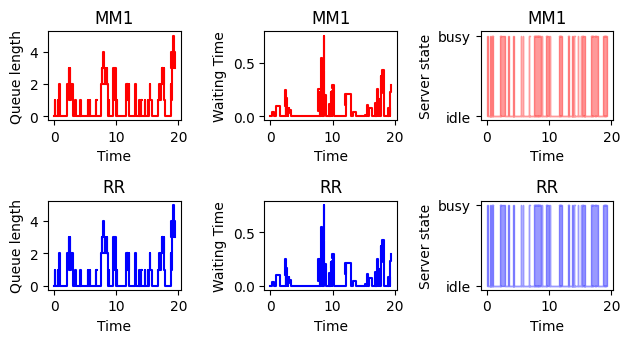

In [12]:
if LOGGED and PLOTTED:
    import matplotlib.pyplot as plt
    colors = {'MM1': 'red', 'RR': 'blue' }
    i = 1
    for service in SERVICE_DISCIPLINE:
        log = np.loadtxt( f'mm1-{service}-l{LAMBDA}-m{MU}.csv', delimiter = '\t' )
        plt.subplot( 3, 3, i )
        plt.xlabel( 'Time' )
        plt.ylabel( 'Queue length' )
        plt.step( log[:200,0], log[:200,2], where='post', color=colors[service] )
        i += 1
        plt.title(f"{service}")

        plt.subplot( 3, 3, i )
        plt.xlabel( 'Time' )
        plt.xlabel( 'Time' )
        plt.ylabel( 'Waiting Time' )
        plt.step( log[:200,0], log[:200,3], where='post', color=colors[service] )
        i += 1
        plt.title(f"{service}")

        plt.subplot( 3, 3, i )
        plt.xlabel( 'Time' )
        plt.ylabel( 'Server state' )
        plt.yticks([0, 1], ['idle', 'busy'])
        #plt.step( log[:200,0], log[:200,1], where='post' )
        plt.fill_between( log[:200,0], 0, log[:200,1], step="post", alpha=.4, color=colors[service] )
        i += 1
        plt.tight_layout()
        plt.title(f"{service}")
    plt.show()  
